In [40]:
'''SMC with an inner HMC step. See the appendix of https://arxiv.org/abs/2007.11936 for details. '''

'SMC with an inner HMC step. See the appendix of https://arxiv.org/abs/2007.11936 for details. '

In [41]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
from jax.scipy.stats import norm,uniform,binom,poisson,nbinom
from numpy.random import default_rng
import numpy as np
import diffrax
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import equinox as eqx
from scipy.special import logsumexp


In [42]:
beta = jnp.log(0.4)
eta = jnp.log(1/7)
gamma = jnp.log(1/14) #0.07
q= jnp.log(0.1)
mu = jnp.log(0.01)
t_vec = jnp.linspace(0,100,100)

def SEIR(t,y,args):
  beta,eta,gamma,q,mu = args

  beta = jnp.exp(beta)
  eta = jnp.exp(eta)
  gamma = jnp.exp(gamma)
  q = jnp.exp(q)
  mu = jnp.exp(mu)

  S,E,I,R = y
  N = S+E+I+R

  dS = - beta * ((E + q * I)/N) * S
  dE = beta * ((E + q * I)/N) * S - eta*E - gamma * E
  dI = eta * E - gamma * I - mu * I
  dR = gamma * E + gamma * I


  return jnp.array([dS,dE,dI,dR])

In [ ]:
def model(ts,y0,par):
  solution = diffrax.diffeqsolve(
            ODETerm(SEIR),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            saveat=diffrax.SaveAt(ts=t_vec)
        )
  return solution.ys

rng_key = jax.random.PRNGKey(0)

y_true = model(t_vec,jnp.array([1000,1.,1.,0]),(beta,eta,gamma,q,mu))

rng = default_rng(1)

data_newI = rng.poisson(jnp.exp(eta) * y_true[:,1] + 0.005)
data_newD = rng.poisson(jnp.exp(mu) * y_true[:,2] + 0.005)


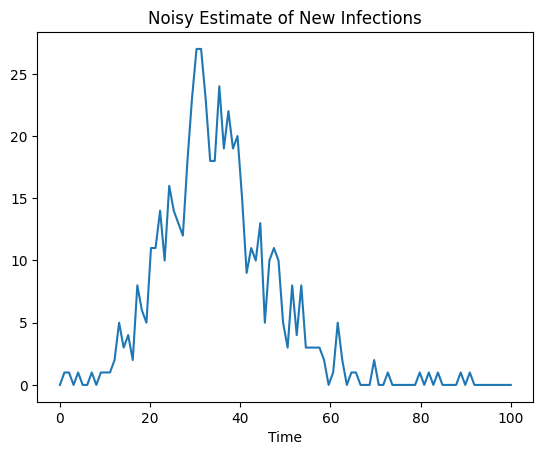

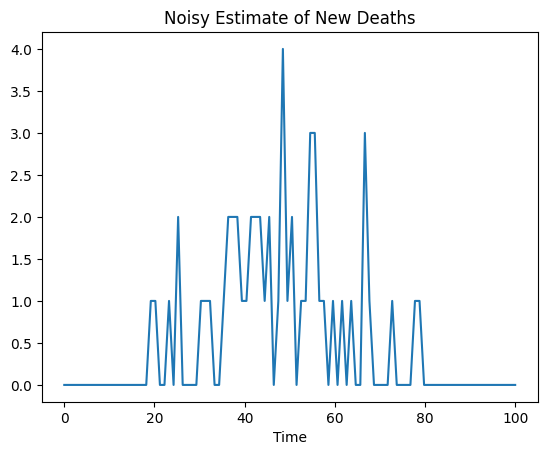

In [ ]:
plt.title('Noisy Estimate of New Infections')
plt.plot(t_vec,data_newI)
plt.xlabel('Time')
plt.show()

plt.title('Noisy Estimate of New Deaths')
plt.xlabel('Time')
plt.plot(t_vec,data_newD)
plt.show()

In [45]:
@jax.jit
def log_likelihood(par):
  beta,eta,gamma,q,mu = par
  model_output = model(t_vec,jnp.array([1000.,1.,1.,0.]),(beta,eta,gamma,q,mu))
  return jnp.sum(poisson.logpmf(data_newI, jnp.exp(eta) * model_output[:,1]) + poisson.logpmf(data_newD,jnp.exp(mu) * model_output[:,2]))

In [46]:
def resampling(weights,rng): 
    '''Resampling function, used inside the smc loop'''

    indices = np.zeros(len(weights),dtype = np.int_) #initialize array to hold the indices
    cdf = np.cumsum(weights)

    u = rng.uniform(0,1/len(weights)) #random number between 1 and 1/n, only drawn once vs the n draws in multinomial resampling
    i = 0
    for j in range(0,len(weights)): 
        r = u + 1/len(weights) * j
        while r > cdf[i]: 
            i += 1
        indices[j] = i

    return indices

In [ ]:
r_scale = 1.
# Kinetic and potential energy functions.
def T(r,beta): 
    return -norm.logpdf(r,scale = r_scale).sum()

def V(x,beta): 
    return -(log_likelihood(x)*beta)

#Gradient of the potential energy
grad_V = jax.jit(jax.grad(V,argnums = (0,)))


In [48]:
#Algorithm

##Define the sequence of intermediate targets
beta_t = np.linspace(0,1,20)

#Constants
par_length = 5
step_size = 0.001
n_steps = 10

#Initial proposal particles
N = 1000
particles = np.zeros((N,par_length))
particles = rng.multivariate_normal(np.array([np.log(0.1),np.log(0.1),np.log(0.1),np.log(0.1),np.log(0.1)]),0.1 * np.eye(5),size = (N,))
velocities = rng.multivariate_normal(np.array([0,0,0,0,0]),r_scale * np.eye(5),size = (N,))

weights = 1/N * np.ones(N)

beta_t1 = 0
for t,beta in enumerate(beta_t[1:]):

    print(f"Iteration: {t}")

    #Resampling step
    indices = resampling(weights,rng)
    particles = particles[indices,:]
    velocities = velocities[indices,:]

    old_particles = particles.copy()
    old_velocities = velocities.copy()
    
    #Mutation/M-Kernel step

    for p_index in range(len(particles)):

        r_prop = rng.normal(0.,r_scale,size = (par_length,))
        x_prop = particles[p_index,:]
        for _ in range(n_steps):
            grad = grad_V(x_prop,beta)[0]
            grad = np.clip(grad,a_min = 1e-3,a_max = 1e3)

            r_prop = r_prop - (step_size / 2) * grad
            x_prop = x_prop + step_size * r_prop
            r_prop = r_prop - (step_size / 2) * grad

        particles[p_index,:] = x_prop
        velocities[p_index,:] = r_prop

        H_curr = T(velocities[p_index,:]) + V(particles[p_index,:],beta)
        H_prev = T(old_velocities[p_index,:]) + V(old_particles[p_index,:],beta_t1)

        #Compute weights
        log_weight = H_prev - H_curr
        weights[p_index] = log_weight

    #Normalize weights
    shifted_log_weights = weights - np.max(weights, keepdims=True)
    underflow_lower_bound = -(10**5)
    clipped_log_weights = np.clip(
    shifted_log_weights, a_min=underflow_lower_bound, a_max=None
        )
    weights = np.exp(clipped_log_weights)
    weights = weights / np.sum(weights, keepdims=True)

    # #Track the previous beta
    beta_t1 = beta

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18


In [49]:
#Last resampling step
indices = resampling(weights,rng)
particles = np.exp(particles[indices,:])

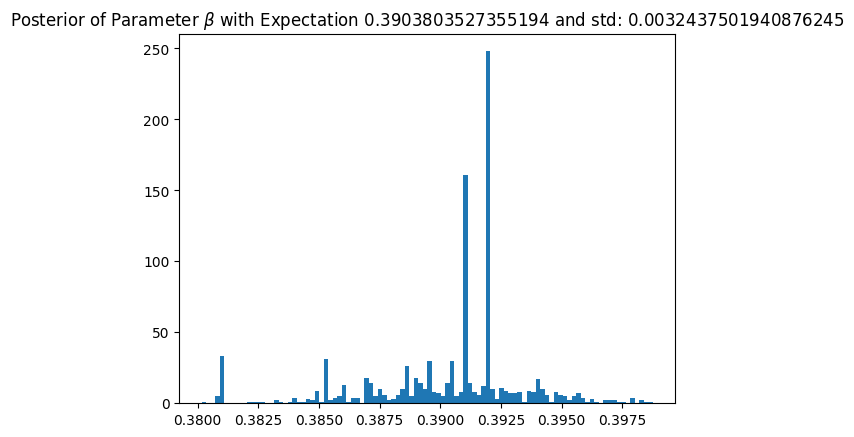

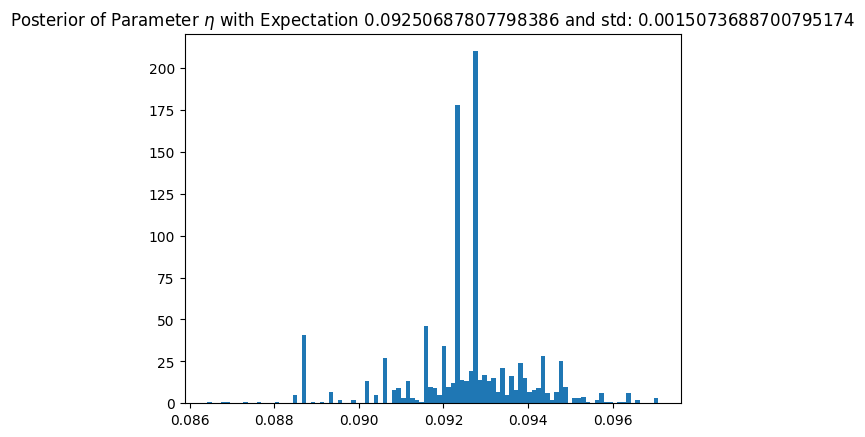

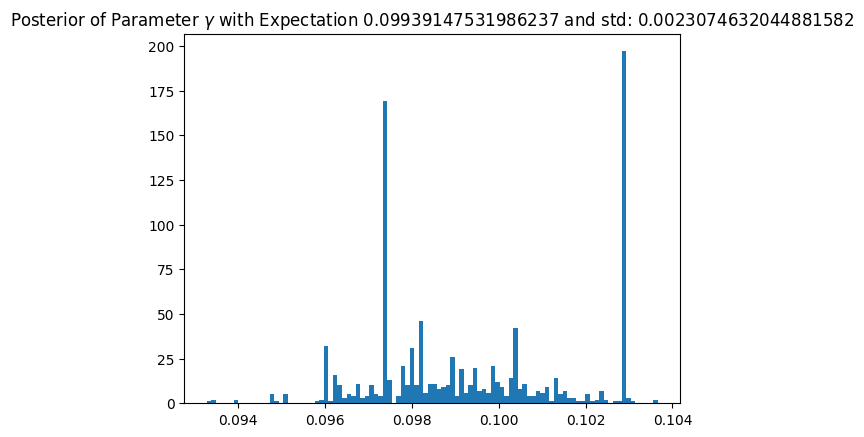

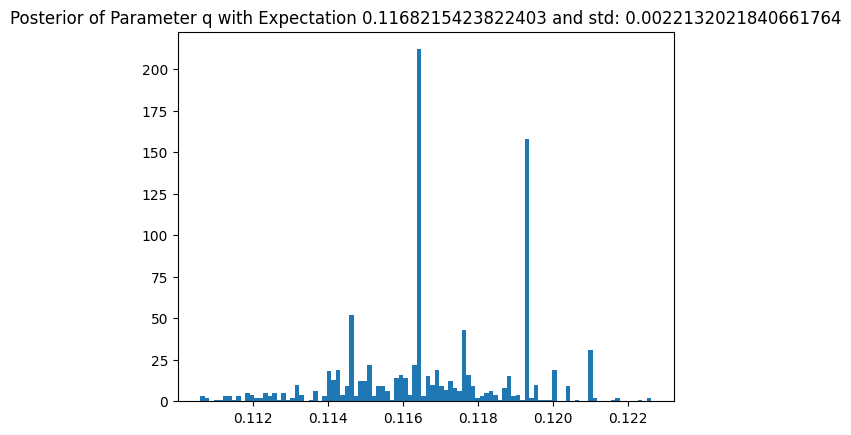

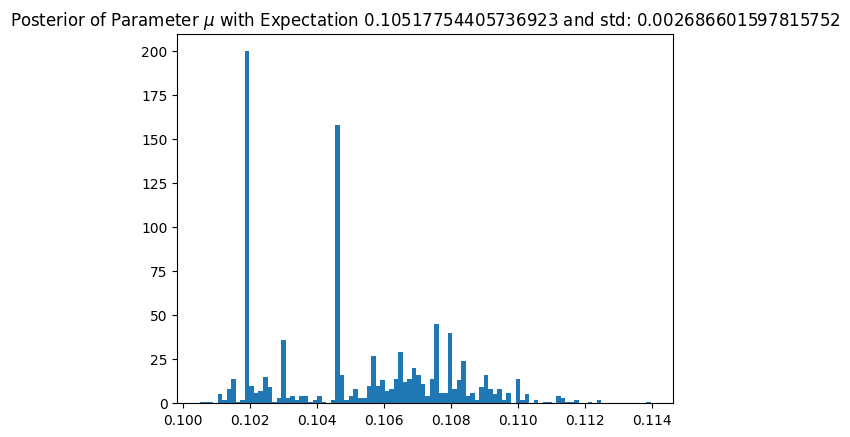

In [50]:

plt.title(f"Posterior of Parameter $\\beta$ with Expectation {jnp.mean(particles[:,0])} and std: {jnp.std(particles[:,0])}")
plt.hist(particles[:,0],bins = 100)
plt.show()

plt.title(f"Posterior of Parameter $\\eta$ with Expectation {jnp.mean(particles[:,1])} and std: {jnp.std(particles[:,1])}")
plt.hist(particles[:,1],bins = 100)
plt.show()

plt.title(f"Posterior of Parameter $\\gamma$ with Expectation {jnp.mean(particles[:,2])} and std: {jnp.std(particles[:,2])}")
plt.hist(particles[:,2],bins = 100)
plt.show()

plt.title(f"Posterior of Parameter q with Expectation {jnp.mean(particles[:,3])} and std: {jnp.std(particles[:,3])}")
plt.hist(particles[:,3],bins = 100)
plt.show()

plt.title(f"Posterior of Parameter $\\mu$ with Expectation {jnp.mean(particles[:,4])} and std: {jnp.std(particles[:,4])}")
plt.hist(particles[:,4],bins = 100)
plt.show()